# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/ata#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

In [5]:
import re # Regular expressions

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link})

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.

In [8]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
print(df.shape)
df.to_csv('craigslist_cville_antiques.csv') # Save data in case of a disaster
df.head()

(176, 4)


,title,price,year,link
0,rare georgia tech versus notre dame football p...,1000,1927.0,https://charlottesville.craigslist.org/atq/d/n...
1,pair antique french empire gilt ormolu bronze ...,500,NaN,https://charlottesville.craigslist.org/atq/d/n...
2,1890 eastlake victorian white marble top vanity,400,NaN,https://charlottesville.craigslist.org/atq/d/n...
3,1959 almost complete set of 9 robert riger she...,80,1959.0,https://charlottesville.craigslist.org/atq/d/n...
4,mcm tension pole lamp,325,NaN,https://charlottesville.craigslist.org/atq/d/n...


Some EDA:

count      176.000000
mean       411.409091
std       1236.435976
min          0.000000
25%         45.000000
50%        125.000000
75%        300.000000
max      12000.000000
Name: price, dtype: float64


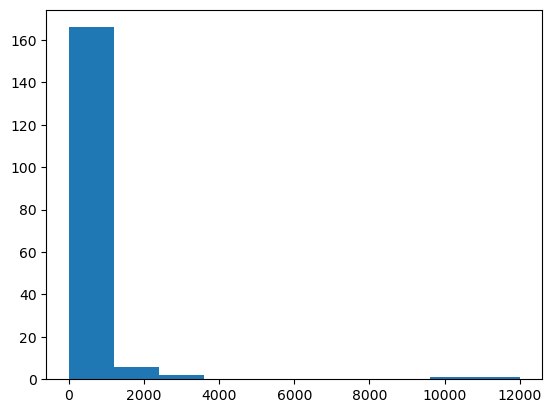

In [13]:
# EDA for price:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()

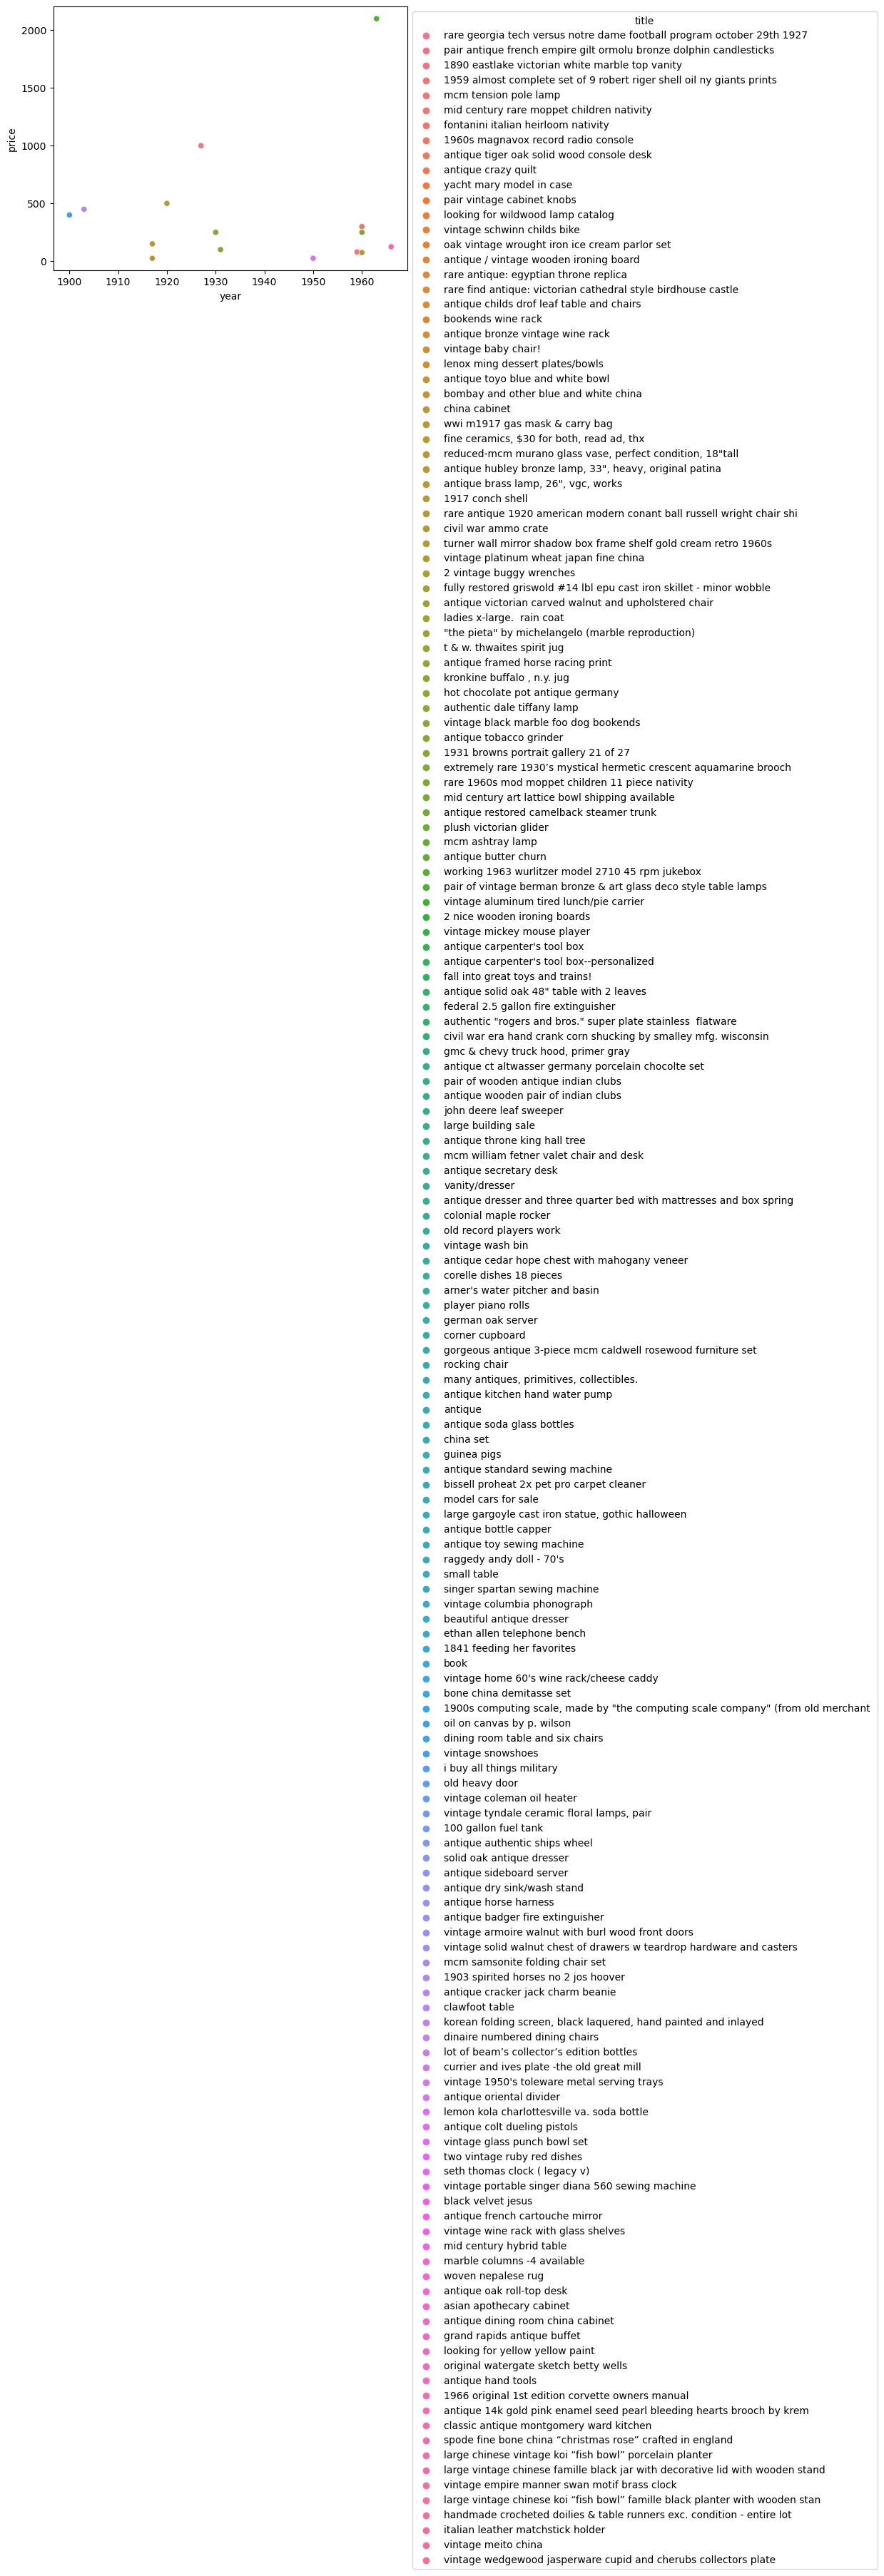

In [15]:
# correlations on scatterplot between brand, price, and age
ax = sns.scatterplot(data=df, x='year', y='price', hue='title')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## 4. (Optional) From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.